**Library**

In [18]:
import pydicom
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pydicom
import glob
from torch._C import dtype
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
#import gdcm
import cv2
import warnings
from fastai.vision.all import *
from fastai.medical.imaging import *
warnings.filterwarnings('ignore')
dataset_path = Path('/home/sangjun.park/siim-covid19-detection')
import vtk
# numba
import numba
from numba import jit
from vtk.util import numpy_support
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from pydicom import dcmread

from matplotlib import pyplot as plt
import random
paddingSize= 0
    


reader = vtk.vtkDICOMImageReader()

# Thanks https://www.kaggle.com/tanlikesmath/siim-covid-19-detection-a-simple-eda
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data


    
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()
    


def image_path(row):
    study_path = dataset_path/'train'/row.StudyInstanceUID
    for i in get_dicom_files(study_path):
        if row.id.split('_')[0] == i.stem: return i 
        


class Config:
    n_folds: int = 5
    seed: int = 2021
    num_classes: int = 4 
    img_size: int = 256
    fold_num: int = 0
    device: str = 'cuda:10.0'



def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(Config.seed)

**make train_image_df**

In [19]:
train_image_df = pd.read_csv('/home/sangjun.park/siim-covid19-detection/train_image_level.csv')

# Thanks https://www.kaggle.com/tanlikesmath/siim-covid-19-detection-a-simple-eda
train_image_df['class'] = train_image_df.label.apply(lambda x: x.split()[0])


train_image_df['x_min'] = train_image_df.label.apply(lambda x: float(x.split()[2]))
train_image_df['y_min'] = train_image_df.label.apply(lambda x: float(x.split()[3]))
train_image_df['x_max'] = train_image_df.label.apply(lambda x: float(x.split()[4]))
train_image_df['y_max'] = train_image_df.label.apply(lambda x: float(x.split()[5]))

def get_bbox_area(row):
    return (row['x_max']-row['x_min'])*(row['y_max']-row['y_min'])


train_image_df['bbox_area'] = train_image_df.apply(get_bbox_area, axis=1)

train_image_df['image_path'] = train_image_df.apply(image_path, axis=1)

imgs = []
image_paths = train_image_df['image_path'].values
class_ids = train_image_df['class']

In [20]:
train_study_df = pd.read_csv('/home/sangjun.park/siim-covid19-detection/train_study_level.csv')
train_study_df["id"] = train_study_df["id"].apply(lambda x: x.split("_")[0])

In [21]:
train_image_df = pd.merge(train_image_df, train_study_df, left_on="StudyInstanceUID", right_on="id")
train_image_df.rename(columns={'id_x':'id'}, inplace=True)
train_image_df.drop(["id_y"], axis=1, inplace=True)
train_image_df['type_id']=[0]*len(train_image_df)

In [22]:
types=train_image_df.columns[-5:-1]
for i, type in enumerate(types):
    """ Negative for Pneumonia : 0
        Typical Appearance : 1
        Indeterminate Appearance : 2
        Atypical Appearance : 3 """
    type_idx=train_image_df[train_image_df[type]==1].index.tolist()
    train_image_df.iloc[type_idx,-1]=i
    
train_image_df.iloc[:,-5:].head(10)

,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,type_id
0,0,1,0,0,1
1,1,0,0,0,0
2,0,1,0,0,1
3,0,0,0,1,3
4,0,1,0,0,1
5,0,0,1,0,2
6,1,0,0,0,0
7,0,1,0,0,1
8,0,1,0,0,1
9,0,1,0,0,1


In [23]:
for i in range(len(train_image_df)):
    label_list = train_image_df.loc[i,"label"].split()
    num = len(label_list)//6
    for j in range(num):
        if j==0:
            train_image_df.loc[i,"label"]=' '.join(label_list[j*6:(j+1)*6])
        else:
            train_image_df=train_image_df.append(train_image_df.iloc[i]).reset_index().drop("index",axis=1)
            last_n=len(train_image_df)-1
            
            train_image_df.loc[last_n, 'label']=' '.join(label_list[j*6:(j+1)*6])
            train_image_df.loc[last_n, 'class'] = label_list[j*6]

            train_image_df.loc[last_n, 'x_min'] = float(label_list[j*6+2])
            train_image_df.loc[last_n, 'y_min'] = float(label_list[j*6+3])
            train_image_df.loc[last_n, 'x_max'] = float(label_list[j*6+4])
            train_image_df.loc[last_n, 'y_max'] = float(label_list[j*6+5])

            train_image_df.loc[last_n, 'bbox_area'] = get_bbox_area(train_image_df.loc[last_n])
            

In [24]:
train_image_df.loc[train_image_df["x_min"]<0,['x_min']]=0.0

In [25]:
train_image_df["id"].value_counts()

b570de3efeed_image    8
9178cdb575d7_image    5
6c08c0dbcf5e_image    4
932dabe18d3c_image    4
5fb9c3bc1e1c_image    4
                     ..
86d6ed01e772_image    1
a5beac3d9fb4_image    1
0dabccf9b632_image    1
68b91c11b2dd_image    1
11c63a24c216_image    1
Name: id, Length: 6334, dtype: int64

In [26]:
pd.DataFrame(valid_ids)

,0
0,d33ad3042402_image
1,d33c3dbebc68_image
2,d342f30b94ac_image
3,d351eafe4a11_image
4,d355ba313f5e_image
...,...
995,ffcc6edd9445_image
996,ffd91a2c4ca0_image
997,ffd9b6cf2961_image
998,ffdc682f7680_image


**Dataloader**

In [27]:
# map label_id to specify color
# label2color = {class_id:[random.randint(0,255) for i in range(3)] for class_id in class_ids}
# thickness = 3
# scale = 5


image_ids = train_image_df['id'].unique()
valid_ids = image_ids[-1000:]# Tran and Validation Split 
train_ids = image_ids[:-5000]


valid_df = train_image_df[train_image_df['id'].isin(valid_ids)]
train_df = train_image_df[train_image_df['id'].isin(train_ids)]

train_df["class_id"] = [1]*len(train_df)
valid_df["class_id"] = [1]*len(valid_df)
print(len(train_image_df))
print(train_df.shape)
train_df.head()

class COVIDTrainDataLoader(Dataset): #Class to load Training Data
    
    def __init__(self, dataframe, transforms=None,stat = 'Train'):
        super().__init__()
        
        self.image_ids = dataframe["id"].unique()
        
        self.df = dataframe
        self.transforms = transforms
        self.stat = stat

        
    def __getitem__(self, index):
        if self.stat == 'Train':
            
            image_id = self.image_ids[index]
            
            records = self.df[(self.df['id'] == image_id)]
            records = records.reset_index(drop=True)
            image = dicom2array(self.df[(self.df['id'] == image_id)]['image_path'].values[0])#dcmread

            #image = ds.pixel_array
           
            '''if "PhotometricInterpretation" in dicom:
                if dicom.PhotometricInterpretation == "MONOCHROME1":
                    image = np.amax(image) - image'''

            intercept =  0.0
            slope =1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

            
            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if records.loc[0, "class_id"] == 0:
                records = records.loc[[0], :]

            boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
            boxes = torch.tensor(boxes, dtype = torch.float32)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
            labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

            # suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['id'] = torch.tensor([index])
            target['area'] = area
            target['iscrowd'] = iscrowd


            if self.transforms:
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                sample = self.transforms(**sample)
                image = sample['image']
                target['boxes'] = torch.tensor(sample['bboxes'])
                target['boxes'] = torch.as_tensor(target['boxes'], dtype = torch.float32)

            if target["boxes"].shape[0] == 0:
                # Albumentation cuts the target (class 14, 1x1px in the corner)
                target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
                target['boxes'] = torch.as_tensor(target['boxes'], dtype = torch.float32)
                target["area"] = torch.tensor([1.0], dtype=torch.float32)
                target["labels"] = torch.tensor([0], dtype=torch.int64)
            
            return image, target, image_ids
        
        else:
                   
            image_id = self.image_ids[index]
            records = self.df[(self.df['id'] == image_id)]
            records = records.reset_index(drop=True)

            image = dicom2array(self.df[(self.df['id'] == image_id)]['image_path'].values[0])#dcmread

            #image = ds.pixel_array

            intercept =  0.0
            slope = 1.0

            if slope != 1:
                image = slope * image.astype(np.float32)
                image = image.astype(np.int16)

            image += np.int16(intercept)


            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if self.transforms:
                sample = {
                    'image': image,
                }
                sample = self.transforms(**sample)
                image = sample['image']

            return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

9893
(2040, 17)


**Albumentations & Metrics**

In [10]:
## Albumentations
def get_train_transform():
    return A.Compose([
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ])

# Thanks https://www.kaggle.com/pestipeti/competition-metric-details-script


@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )


    return overlap_area / union_area

@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()


    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.
       The mean average precision at different intersection over union (IoU) thresholds.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

iou_thresholds = [0.5]

class EvalMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.image_precision = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, gt_boxes, pred_boxes, n=1):       
        """ pred_boxes : need to be sorted."""
        
        self.image_precision = calculate_image_precision(pred_boxes,
                                                         gt_boxes,
                                                         thresholds=iou_thresholds,
                                                         form='pascal_voc')
        self.count += n
        self.sum += self.image_precision * n
        self.avg = self.sum / self.count

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = COVIDTrainDataLoader(train_df, get_train_transform())
valid_dataset = COVIDTrainDataLoader(valid_df, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
# Create train and validate data loader
train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

**Training**

In [12]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs =  20 #low epoch to save GPU time
loss_hist = Averager()
itr = 1
lossHistoryiter = []
lossHistoryepoch = []

import time
start = time.time()

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        loss_dict = model(images, targets)  

        losses = sum(loss for loss in loss_dict.values())

        loss_value = losses.item()

        loss_hist.send(loss_value)
        lossHistoryiter.append(loss_value)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    lossHistoryepoch.append(loss_hist.value)
    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time taken to Train the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Iteration #50 loss: 0.3437741994857788
Iteration #100 loss: 0.27594926953315735
Iteration #150 loss: 0.21420696377754211
Iteration #200 loss: 0.2793256640434265
Iteration #250 loss: 0.3814445734024048
Iteration #300 loss: 0.18045085668563843
Iteration #350 loss: 0.1977384388446808
Iteration #400 loss: 0.3860551714897156
Iteration #450 loss: 0.35083386301994324
Iteration #500 loss: 0.492408812046051
Iteration #550 loss: 0.5082622766494751
Iteration #600 loss: 0.12620268762111664
Iteration #650 loss: 0.322221040725708
Epoch #0 loss: 0.38306329673019307
Iteration #700 loss: 0.38442564010620117
Iteration #750 loss: 0.12128593027591705
Iteration #800 loss: 0.2759466767311096
Iteration #850 loss: 0.22608532011508942
Iteration #900 loss: 0.43079617619514465
Iteration #950 loss: 0.22641779482364655
Iteration #1000 loss: 0.24688737094402313
Iteration #1050 loss: 0.24954020977020264
Iteration #1100 loss: 0.10633054375648499
Iteration #1150 loss: 0.1827840358018875
Iteration #1200 loss: 0.1480077

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 22.17 GiB total capacity; 1.90 GiB already allocated; 4.81 MiB free; 8.82 GiB reserved in total by PyTorch)

**save model**

In [28]:
PATH = '/home/sangjun.park/model/'
#torch.save(model, PATH + 'multi_box_class2_sgd0.0001.pt')
model = torch.load(PATH + 'multi_box.pt')
model.eval()

model.to(device)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

**valid Dataloader & mAP**

In [15]:
class COVIDValidDataLoader(Dataset): #Class to load Training Data
    
    def __init__(self, dataframe, transforms=None,stat = 'Train'):
        super().__init__()
        
        self.image_ids = dataframe["id"].unique()
        
        self.df = dataframe
        self.transforms = transforms
        self.stat = stat
        
    def __getitem__(self, index):
        if self.stat == 'Train':
            
            image_id = self.image_ids[index]
            
            records = self.df[(self.df['id'] == image_id)]
            records = records.reset_index(drop=True)
            image = dicom2array(self.df[(self.df['id'] == image_id)]['image_path'].values[0])#dcmread

            #image = ds.pixel_array
           
            '''if "PhotometricInterpretation" in dicom:
                if dicom.PhotometricInterpretation == "MONOCHROME1":
                    image = np.amax(image) - image'''

            intercept =  0.0
            slope =1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

            
            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if records.loc[0, "class_id"] == 0:
                records = records.loc[[0], :]

            boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
            labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

            # suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            #target['id'] = torch.tensor([index])
            target['id'] = image_id
            target['area'] = area
            target['iscrowd'] = iscrowd

            if self.transforms:
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                sample = self.transforms(**sample)
                image = sample['image']

                target['boxes'] = torch.tensor(sample['bboxes'])

            if target["boxes"].shape[0] == 0:
                # Albumentation cuts the target (class 14, 1x1px in the corner)
                target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
                target["area"] = torch.tensor([1.0], dtype=torch.float32)
                target["labels"] = torch.tensor([0], dtype=torch.int64)
            
            return image, target, image_id
        
        else:
                   
            image_id = self.image_ids[index]
            records = self.df[(self.df['id'] == image_id)]
            records = records.reset_index(drop=True)

            image = dicom2array(self.df[(self.df['id'] == image_id)]['image_path'].values[0])#dcmread

            #image = ds.pixel_array

            intercept =  0.0
            slope = 1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if self.transforms:
                sample = {
                    'image': image,
                }
                sample = self.transforms(**sample)
                image = sample['image']

            return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [16]:
valid_dataset = COVIDValidDataLoader(valid_df, get_valid_transform())

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [17]:
def format_prediction_string(image_id,labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
#         pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
#             j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))
          pred_strings.append([image_id,j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]])

    return pred_strings

In [18]:
model.eval()
detection_threshold = 0.5
results = []
answers = []

with torch.no_grad():
    # pred_boxes (list) : [[train_idx, class_pred, prob_score, x1, y1, x2, y2], ... ]    
    for images, targets, image_ids in valid_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
        
        outputs = model(images)

        for i,target in enumerate(targets):
            answer = [target['id'],target['labels'][0].item(),1, 
                      target['boxes'][0][0].item(), target['boxes'][0][1].item(), target['boxes'][0][2].item(), target['boxes'][0][3].item()]
            answers.append(answer)
           
        for i, image in enumerate(images):
            
            image_id = image_ids[i]

            result = [[image_id, 0, 1, 0, 0, 1, 1]]

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()
           
            
            if len(boxes) > 0:

#                 labels = labels - 1
#                 labels[labels == -1] = 1

                selected = scores >= detection_threshold
        
                boxes = boxes[selected].astype(np.int32)
                scores = scores[selected]
                labels = labels[selected]
                
#                 for j in range(len(boxes)):
#                     if boxes[j]<0:
#                         boxes[j]=0
                
                if len(boxes) > 0:
#                     result = {
#                         'image_id': image_id,
#                         'PredictionString': format_prediction_string(image_id,labels, boxes, scores)
#                     }
                    
                    result = format_prediction_string(image_id,labels,boxes,scores)
        
            results.extend(result)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 22.17 GiB total capacity; 2.39 GiB already allocated; 4.81 MiB free; 8.82 GiB reserved in total by PyTorch)

In [ ]:

from collections import Counter

def iou_calc(bb1, bb2):
    ## 오른쪽 좌표가 왼쪽 좌표보다 커야 하고, 위 좌표가 아래 좌표보다 커야 함 그렇지 않을 경우 asserterror
#     assert bb1['x1'] < bb1['x2']
#     assert bb1['y1'] < bb1['y2']
#     assert bb2['x1'] < bb2['x2']
#     assert bb2['y1'] < bb2['y2']

    ## 두개의 bounding box가 겹치는 영역의 좌표
    x_left = max(bb1[0], bb2[0])
    x_right = min(bb1[2], bb2[2])
    y_bottom = max(bb1[1], bb2[1])
    y_top = min(bb1[3], bb2[3])

    if x_right < x_left or y_top < y_bottom: return 0

    intersection_area = (x_right - x_left) * (y_top - y_bottom)

    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    iou = intersection_area / (bb1_area + bb2_area - intersection_area)

    assert iou <= 1
    assert iou >= 0
    return iou

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format='corners', num_classes=3):
    # pred_boxes (list) : [[train_idx, class_pred, prob_score, x1, y1, x2, y2], ... ]
    average_precisions = []
    epsilon = 1e-6

    # 각각의 클래스에 대한 AP를 구합니다.
    for c in [1,2,3]:
        detections = []
        ground_truths = []

        # 모델이 c를 검출한 bounding box를 detections에 추가합니다.
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        # 실제 c 인 bounding box를 ground_truths에 추가합니다.
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # amount_bboxes에 class에 대한 bounding box 개수를 저장합니다.
        # 예를 들어, img 0은 3개의 bboxes를 갖고 있고 img 1은 5개의 bboxes를 갖고 있으면
        # amount_bboexs = {0:3, 1:5} 가 됩니다.
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # class에 대한 bounding box 개수 만큼 0을 추가합니다.
        # amount_boxes = {0:torch.tensor([0,0,0]), 1:torch.tensor([0,0,0,0,0])}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # detections를 정확도 높은 순으로 정렬합니다.
        detections.sort(key=lambda x: x[2], reverse=True)

        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

		# TP와 FP를 구합니다.
        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]]
            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = iou_calc(torch.tensor(detection[3:]),
                                              torch.tensor(gt[3:]),)

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            else:
                FP[detection_idx] = 1
        
        # cumsum은 누적합을 의미합니다.
        # [1, 1, 0, 1, 0] -> [1, 2, 2, 3, 3]
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]),recalls))
        
        # torch.trapz(y,x) : x-y 그래프를 적분합니다.
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [ ]:
mean_average_precision(results,answers)

**valid_ground truth**

In [75]:
results_df=pd.DataFrame(results)
results_df.columns=['image_id', 'pred_type', 'prob_score', 'x_min', 'y_min', 'x_max', 'y_max']

imgs = []
valid_image_ids = results_df['image_id'].values
type_ids = train_image_df['type_id']

# map label_id to specify color
#label2color = {type_id:[random.randint(0,255) for i in range(3)] for type_id in type_ids}
label2color = {0: [0, 0, 0],
               1: [255, 0, 0],
               2: [0, 255, 0],
               3: [0, 0, 255]}
thickness = 3
scale = 5

def label_to_name(label):
    if label == 0 : name ="Negative for Pneumonia"
    elif label == 1 : name = "Typical Appearance"
    elif label == 2: name = "Indeterminate Appearance"
    elif label == 3: name = "Atypical Appearance"
    return name

/home/sangjun.park/siim-covid19-detection/train/1d001accdcbd/e7123b218acf/32663bd94fbf.dcm
[array([385.76976 ,  82.641922, 509.149082, 224.444418])]


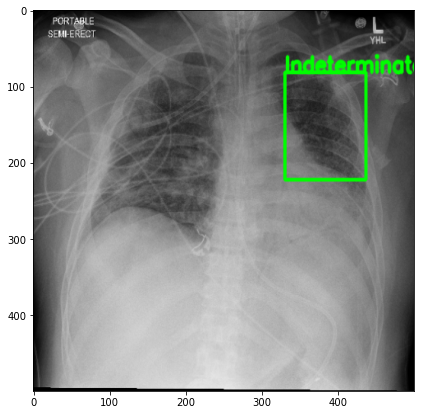

/home/sangjun.park/siim-covid19-detection/train/db9298d9ded8/726a2e77d4f5/32a47637d8f2.dcm
[array([151.706682, 156.22369 , 236.785638, 444.236874]), array([588.956682, 223.171058, 683.798772, 460.276332])]


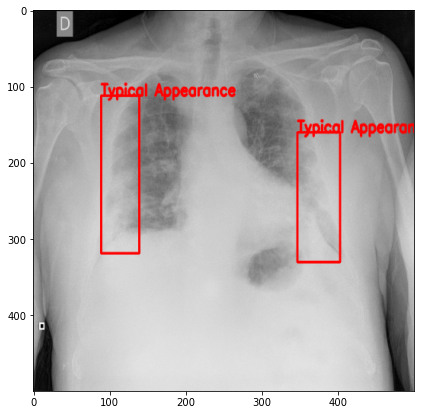

/home/sangjun.park/siim-covid19-detection/train/1d001accdcbd/c8403ab41f28/646a6a0a9bf2.dcm
[array([0. , 0. , 0.2, 0.2])]


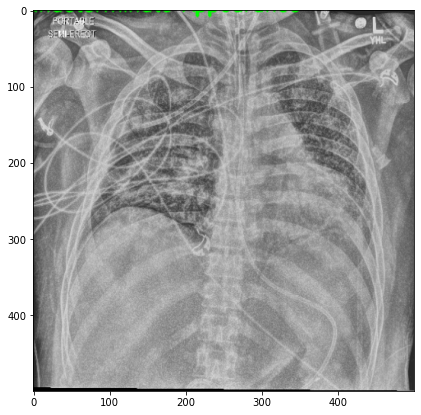

/home/sangjun.park/siim-covid19-detection/train/6320290accf8/8e34eaaadf8b/32db31429adc.dcm
[array([388.612152, 252.658292, 521.07929 , 410.237686])]


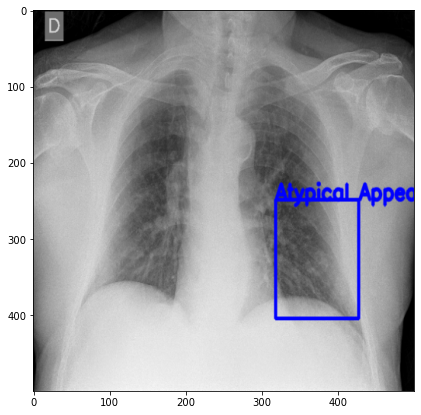

/home/sangjun.park/siim-covid19-detection/train/82d0600dbf57/4774a83b72b6/32704c6f65de.dcm
[array([138.880548, 376.704   , 399.317882, 555.754666]), array([538.83788, 369.728  , 776.02188, 516.224  ])]


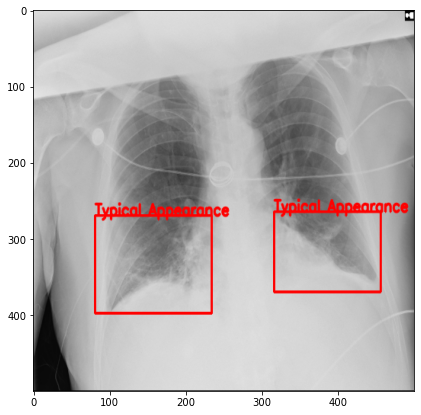

/home/sangjun.park/siim-covid19-detection/train/295c226093ed/2e5f9a94da7a/32bc4b819bf6.dcm
[array([ 82.780788,  36.02933 , 250.523904, 351.433618]), array([328.489004,  72.05866 , 504.501138, 378.012622])]


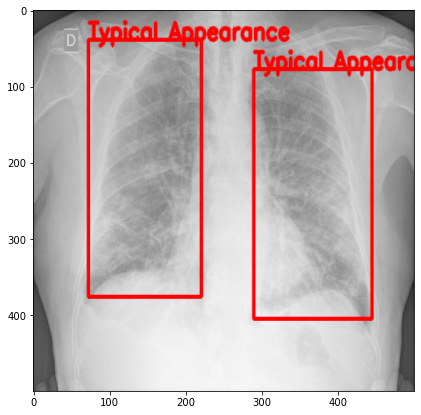

/home/sangjun.park/siim-covid19-detection/train/9113eb5c46c2/c525db0c40e2/32385ecafe4c.dcm
[array([ 57.596742, 165.763748, 172.21426 , 328.18655 ]), array([111.16171 ,  67.849288, 213.107938, 154.820364]), array([306.990632,  59.785744, 418.15235 , 199.169862]), array([365.16334 , 264.830144, 478.628916, 332.79428 ])]


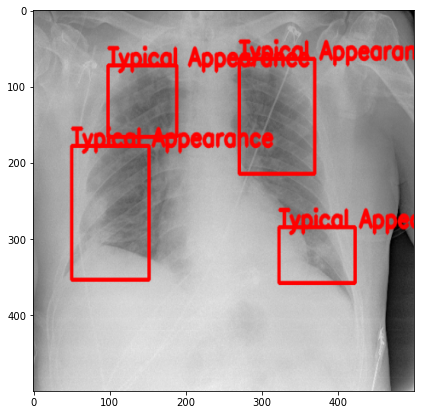

/home/sangjun.park/siim-covid19-detection/train/419b460cc514/0702ca7e3764/32456961c278.dcm
[array([129.1875  , 201.42188 , 339.53125 , 665.083302]), array([477.552084, 214.67188 , 727.093734, 579.59898 ])]


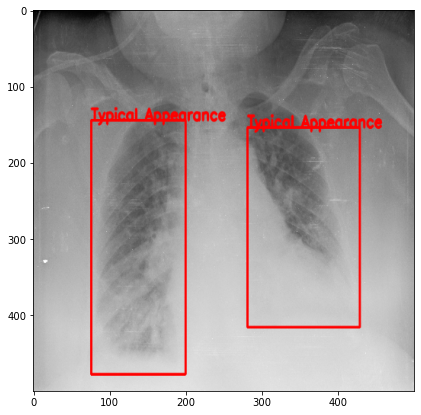

In [100]:
sample_paths=[]
sample_ids=[]
for i in range(8):
    id = random.choice(valid_image_paths)
    sample_ids.append(id)
    
    image_path = valid_df.loc[valid_df['id']==id, ['image_path']].values[0][0]
    img = dicom2array(str(image_path))
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    label = valid_df.loc[valid_df['image_path'] == image_path, ['type_id']].values[0][0]
    
    sample_paths.append(image_path)
    print(image_path)
    
    boxes=[]
    num = valid_df.loc[valid_df['id']==id, ['image_path']].count()[0]
    for j in range(num):
        box = valid_df.loc[valid_df['image_path'] == image_path, ['x_min', 'y_min', 'x_max', 'y_max']].values[j]/scale
        boxes.append(box)
        
        color = label2color[label]
        img = cv2.rectangle(
            img,
            (int(boxes[j][0]), int(boxes[j][1])),
            (int(boxes[j][2]), int(boxes[j][3])),
            color, thickness)
        img = cv2.putText(img, label_to_name(label), (int(boxes[j][0]), int(boxes[j][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3, cv2.LINE_AA)

    img = cv2.resize(img, (500,500))
    imgs.append(img)
    print(boxes)
    
    plot_img(img, cmap=None)

**valid_predict**

/home/sangjun.park/siim-covid19-detection/train/1d001accdcbd/e7123b218acf/32663bd94fbf.dcm
[array([403.8,  96.2, 530.8, 333.4]), array([ 80. ,  54. , 304.8, 302.6])]


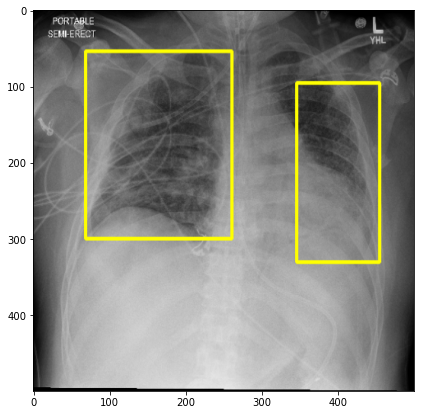

/home/sangjun.park/siim-covid19-detection/train/db9298d9ded8/726a2e77d4f5/32a47637d8f2.dcm
[array([152. , 148.2, 323.6, 444.6]), array([468.2, 127. , 669.4, 419.6])]


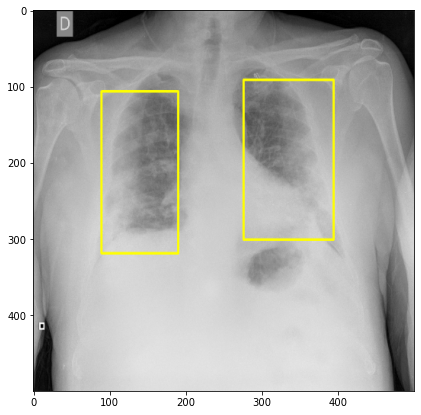

/home/sangjun.park/siim-covid19-detection/train/1d001accdcbd/c8403ab41f28/646a6a0a9bf2.dcm
[array([378.8,  78.6, 529.2, 322. ])]


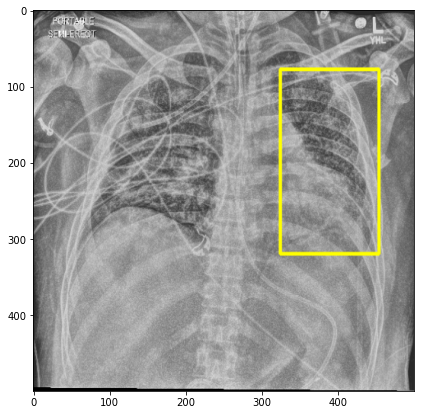

/home/sangjun.park/siim-covid19-detection/train/6320290accf8/8e34eaaadf8b/32db31429adc.dcm
[array([343.4, 192.6, 508.2, 403.2]), array([107.8, 163.4, 232.2, 374.8])]


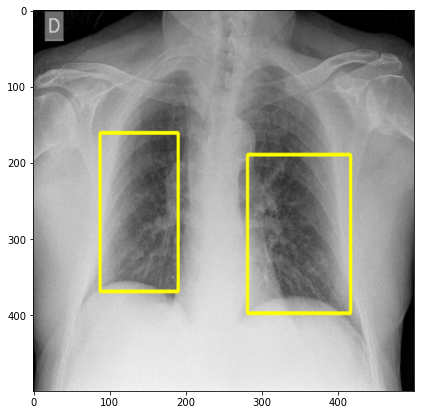

/home/sangjun.park/siim-covid19-detection/train/82d0600dbf57/4774a83b72b6/32704c6f65de.dcm
[array([150.6, 285.6, 372. , 543.2]), array([496.8, 286. , 748. , 498. ]), array([145.2, 128.2, 411.4, 580.6])]


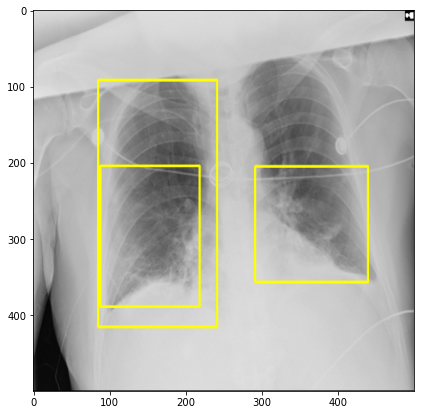

/home/sangjun.park/siim-covid19-detection/train/295c226093ed/2e5f9a94da7a/32bc4b819bf6.dcm
[array([347.4,  96.2, 506.4, 389.6]), array([ 67.4, 148.6, 189.2, 365.2]), array([ 61.6,  83.6, 256. , 398.6])]


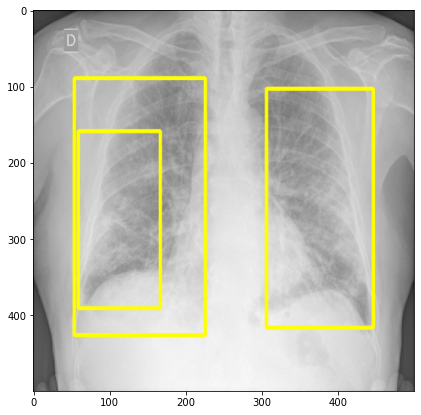

/home/sangjun.park/siim-covid19-detection/train/9113eb5c46c2/c525db0c40e2/32385ecafe4c.dcm
[array([ 68.2,  95.6, 190.2, 310.2]), array([302.8,  67.2, 452.2, 331.4]), array([350.2, 175.6, 466.2, 338.6])]


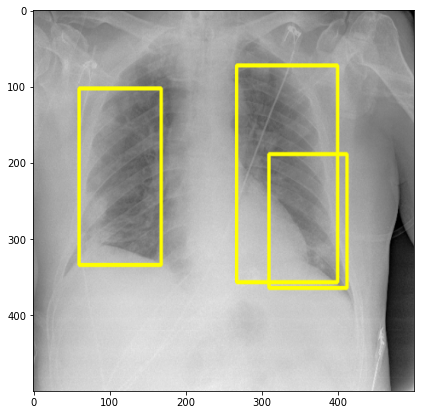

/home/sangjun.park/siim-covid19-detection/train/419b460cc514/0702ca7e3764/32456961c278.dcm
[array([132.2, 187.2, 320.8, 636.8]), array([119.2, 391. , 302.6, 645.2]), array([539. , 246. , 713. , 508.6])]


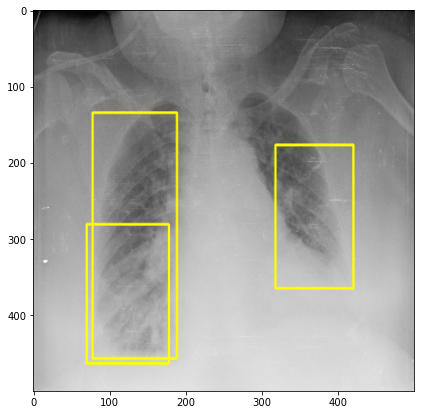

In [101]:
for i in range(8):
    image_path = sample_paths[i]
    image_id = sample_ids[i]
    print(sample_paths[i])
    
    img = dicom2array(str(image_path))
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    label = results_df.loc[results_df['image_id'] == image_id, ['pred_type']].values[0][0]
    
    boxes=[]
    num = results_df.loc[results_df['image_id'] == image_id].count()[0]
    for j in range(num):
        box = results_df.loc[results_df['image_id'] == image_id, ['x_min', 'y_min', 'x_max', 'y_max']].values[j]/scale
        boxes.append(box)
        
        color = [255,255,0]
        img = cv2.rectangle(
            img,
            (int(boxes[j][0]), int(boxes[j][1])),
            (int(boxes[j][2]), int(boxes[j][3])),
            color, thickness)
    
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    print(boxes)
    
    plot_img(img, cmap=None)    

**test**

In [21]:
test_df = pd.read_csv('/home/sangjun.park/siim-covid19-detection/sample_submission.csv')

def study_path(row):
    study_path = dataset_path/'test'/row.id.split("_")[0]
    for i in get_dicom_files(study_path):
        return i 
        
test_df['image_path'] = test_df.apply(study_path, axis=1)
test_df["image_path"] = test_df["image_path"].apply(str)
test_df.head()

,id,PredictionString,image_path
0,00188a671292_study,negative 1 0 0 1 1,/home/sangjun.park/siim-covid19-detection/test/00188a671292/3eb5a506ccf3/3dcdfc352a06.dcm
1,004bd59708be_study,negative 1 0 0 1 1,/home/sangjun.park/siim-covid19-detection/test/004bd59708be/e7d024ea82d7/c39146cbda47.dcm
2,00508faccd39_study,negative 1 0 0 1 1,/home/sangjun.park/siim-covid19-detection/test/00508faccd39/d39fc1121992/951211f8e1bb.dcm
3,006486aa80b2_study,negative 1 0 0 1 1,/home/sangjun.park/siim-covid19-detection/test/006486aa80b2/fe138b3d009e/5e0e7acd9c7d.dcm
4,00655178fdfc_study,negative 1 0 0 1 1,/home/sangjun.park/siim-covid19-detection/test/00655178fdfc/2e01129e9043/5b8ee5baa1d5.dcm


In [22]:
def image_file_path(row):
    s = row.id.split("_")[0]

    try:
        return test_df.loc[test_df["image_path"].str.contains(s)]["image_path"].values[0]
    except:
        #print(s)
        return ""

In [23]:
test_df[test_df.image_path == "None"].apply(image_file_path,axis = 1)
Na_test_df = test_df[test_df.image_path == ""]
test_df = test_df[test_df.image_path != ""]

In [24]:
test_dataset = COVIDTrainDataLoader(test_df, get_test_transform(),"Test")

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)

In [26]:
images, image_ids = next(iter(test_data_loader))
images = list(image.to(device) for image in images)

for number in random.sample([1,2,3],3):
    img = images[number].permute(1,2,0).cpu().numpy()
    #labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
#     fig, ax = plt.subplots(1, 1, figsize=(16, 8))
#     ax.set_axis_off()
#     ax.imshow(img)

In [ ]:
model.eval()
images = list(img.to(device) for img in images)

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [ ]:
def label_to_name(label):
    if label == 1 : name = "Typical Appearance"
    elif label == 2: name = "Indeterminate Appearance"
    elif label == 3: name = "Atypical Appearance"
    return name
    

boxes = outputs[2]['boxes'].cpu().detach().numpy().astype(np.int32)
img = images[2].permute(1,2,0).cpu().detach().numpy()
labels= outputs[2]['labels'].cpu().detach().numpy().astype(np.int32)
score = outputs[2]['scores']

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

img = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2BGR)
for i in range(len(boxes)):
    img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),20)
    img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,3, (255,0,0), 3, cv2.LINE_AA)

ax.set_axis_off()
ax.imshow(img)